In [1]:
#glomTI composition analysis
project_dir = "~/ben_lustre/current_projects/kidney_glomTI_response"
setwd(project_dir)
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
sp = import("scipy")

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
library(miloR)
library(dplyr)

Loading required package: edgeR

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm



Attaching package: ‘miloR’


The following object is masked from ‘package:igraph’:

    graph



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, inters

In [3]:
#some plotting functions 
plotNhood <- function(x, redDim = "X_umap", color_by = LFC, alpha = 1, 
                      size_scale = c(0.1, 5)){
  layout <- reducedDim(x, redDim)[unlist(x@nhoodIndex), ]
  size <- colSums(x@nhoods)
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size)
  pl <- ggplot(df, aes(x = x, y=y, 
                       size = size, fill = size)) + geom_point(pch = 21, alpha = alpha, color ="black") +
    theme_void() + scale_size(range = size_scale, name = "Nhood size")
  return(pl)
}
plotNhoodDA <- function(x, redDim = "X_umap",da_results, alpha=1, size_scale = c(0.1, 5),
                        color_scheme = scale_color_gradient2(low = "darkblue", mid ="grey90", high = "darkred" , limits = c(-6, 6))){
  layout <- reducedDim(x, redDim)[unlist(x@nhoodIndex), ]
  size <- colSums(x@nhoods)
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size)
  LFC <- da_results$logFC
  df <- data.frame(x= layout[, 1], y = layout[, 2], size = size, 
                   LFC = LFC)
  pl <- ggplot(df, aes(x = x, y=y, 
                       size = size, color = LFC)) + ggrastr::geom_point_rast(pch = 19, alpha = alpha) +
    theme_void() + scale_size(range = size_scale, name = "Nhood size") + color_scheme
  return(pl)
}
da_colors <-  scale_color_gradient2(low = "darkred", mid ="grey90", high = "darkblue" , limits = c(-10, 10))
da_fills <-  scale_fill_gradient2(low = "darkred", mid ="grey70", high = "darkblue" , limits = c(-10, 10))

In [4]:
py_config()

python:         /home/jovyan/my-conda-envs/myenv/bin/python
libpython:      /home/jovyan/my-conda-envs/myenv/lib/libpython3.9.so
pythonhome:     /home/jovyan/my-conda-envs/myenv:/home/jovyan/my-conda-envs/myenv
version:        3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:18:18)  [GCC 10.4.0]
numpy:          /home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by RETICULATE_PYTHON

In [5]:
adata = sc$read_h5ad("data/annotated/scRNAseq_glom_TI_kidney.h5ad")

In [6]:
table(adata$obs$tissue)


    Glomerulus_single_cell_suspension TI_compartment_single_cell_suspension 
                               100358                                 61314 
        kidney_single_cell_suspension 
                                13099 

In [7]:
#subset to glom and TI
adata = adata[adata$obs$tissue %in% c("Glomerulus_single_cell_suspension", "TI_compartment_single_cell_suspension")]

In [8]:
#construct an SCE
library(SingleCellExperiment)

In [9]:
sce = SingleCellExperiment(assays = list('counts' = t(adata$layers['raw_counts']), 'exprs' = t(adata$X) ),
                                    colData = adata$obs, rowData = adata$var)

In [10]:
reducedDims(sce) = list('X_scVI' = adata$obsm['X_scVI'], 'X_umap' = adata$obsm['X_umap'])

In [11]:
sce

class: SingleCellExperiment 
dim: 1846 161672 
metadata(0):
assays(2): counts exprs
rownames(1846): MXRA8 PRDM16 ... NLGN4Y TTTY14
rowData names(16): ID Symbol ... variances_norm
  highly_variable_nbatches
colnames(161672):
  AAACCCATCCTTCACG-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A
  AAACGAACAATTGGTC-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A
  ...
  TTTGTTGTCATGCCAA-1_cellranger700_count_46409_KID_CZI13249527_GRCh38-2020-A
  TTTGTTGTCATGCTAG-1_cellranger700_count_46409_KID_CZI13249527_GRCh38-2020-A
colData names(76): barcode path ... compartment broad_cell_type
reducedDimNames(2): X_scVI X_umap
mainExpName: NULL
altExpNames(0):

In [12]:
#make a milo object for this analysis
milo <- Milo(sce)

In [13]:
#build the k=30 kNN graph
d = ncol(reducedDim(sce, 'X_scVI'))
k = 30
milo <- buildGraph(milo, k = k, d=d, reduced.dim = "X_scVI")

Constructing kNN graph with k:30



In [14]:
milo <- makeNhoods(milo, prop = 0.1, k = k, d=d, refined = TRUE, reduced_dims = "X_scVI")

Checking valid object

Running refined sampling with reduced_dim



In [15]:
milo <- calcNhoodDistance(milo, d=d, reduced.dim = "X_scVI")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



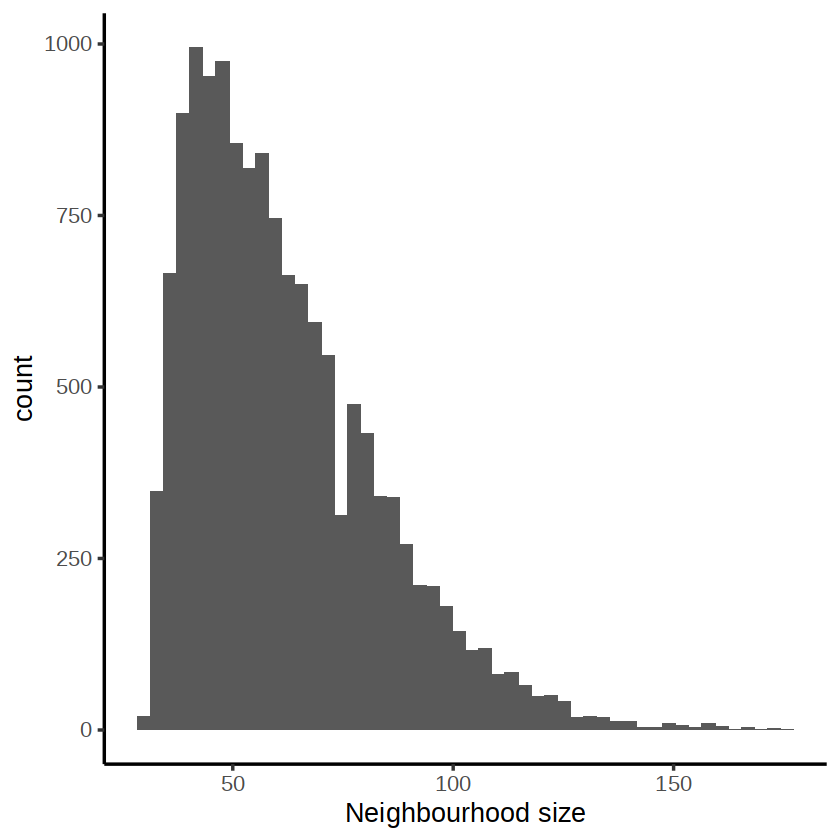

In [16]:
plotNhoodSizeHist(milo)

In [17]:
table(colData(milo)$donor)


     GPD1      K232      K241      K245      K247 K250_K251      K254      K255 
     1891      9438      7748      6664     14958     30376      8733      8117 
     K257      K260      K262      K269      K270      K271      K272      K273 
     5036      1406      2881      4111     14323     12844      3222      7140 
     K275      K277      K278      K294 
     4275     11499      1215      5795 

In [18]:
colData(milo)$replicate = paste0(colData(milo)$donor, "_", colData(milo)$channel) #kidneys are across multiple channels, so we have more replicates.

In [19]:
milo <- countCells(milo, meta.data = as.data.frame(colData(milo)), sample="replicate")

Checking meta.data validity

Counting cells in neighbourhoods



In [20]:
#get a design
design <- data.frame(colData(milo))[,c("replicate", "tissue")]

In [21]:
design <- dplyr::distinct(design)
rownames(design) <- design$replicate

In [22]:
da_results <- testNhoods(milo, design = ~ tissue, norm.method = 'logMS',
                         design.df = design, reduced.dim = 'X_scVI')

Using logMS normalisation

Performing spatial FDR correction withk-distance weighting



In [23]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12387,5.036457,8.664360,139.7306,4.039071e-22,5.739520e-18,12387,4.748998e-18
6132,4.716752,8.500747,136.3780,9.017239e-22,6.406748e-18,6132,5.208011e-18
5041,4.568538,8.428134,126.8158,9.447605e-21,2.237508e-17,5041,1.878309e-17
5380,4.207529,8.297251,128.1621,6.750332e-21,2.237508e-17,5380,1.878309e-17
13378,4.222266,8.285335,127.6494,7.670757e-21,2.237508e-17,13378,1.878309e-17
14109,4.546202,8.429689,127.3914,8.181109e-21,2.237508e-17,14109,1.878309e-17


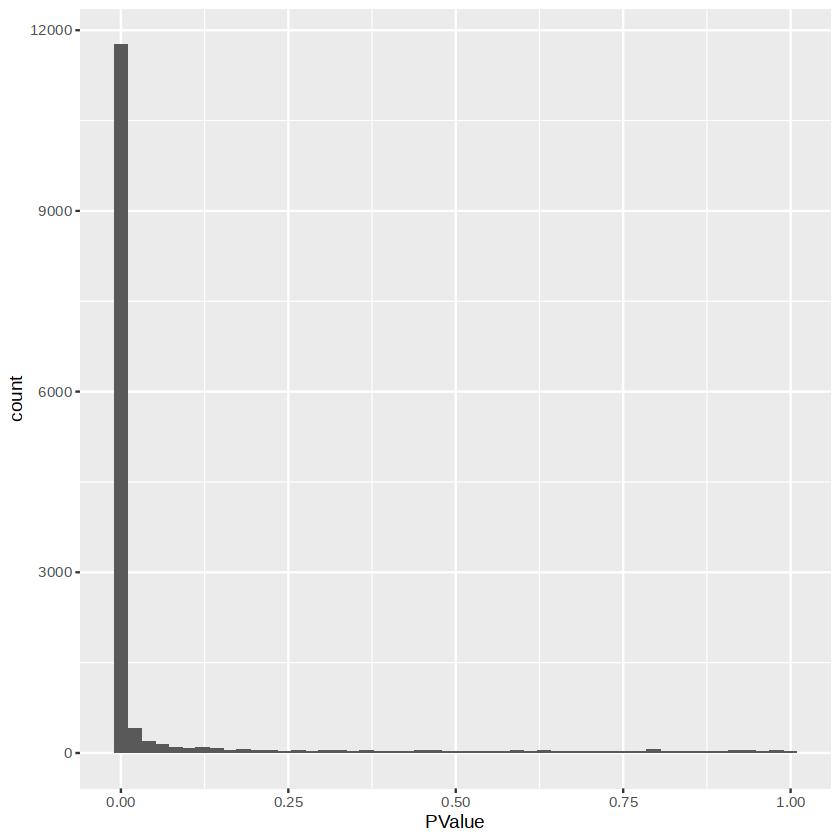

In [24]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

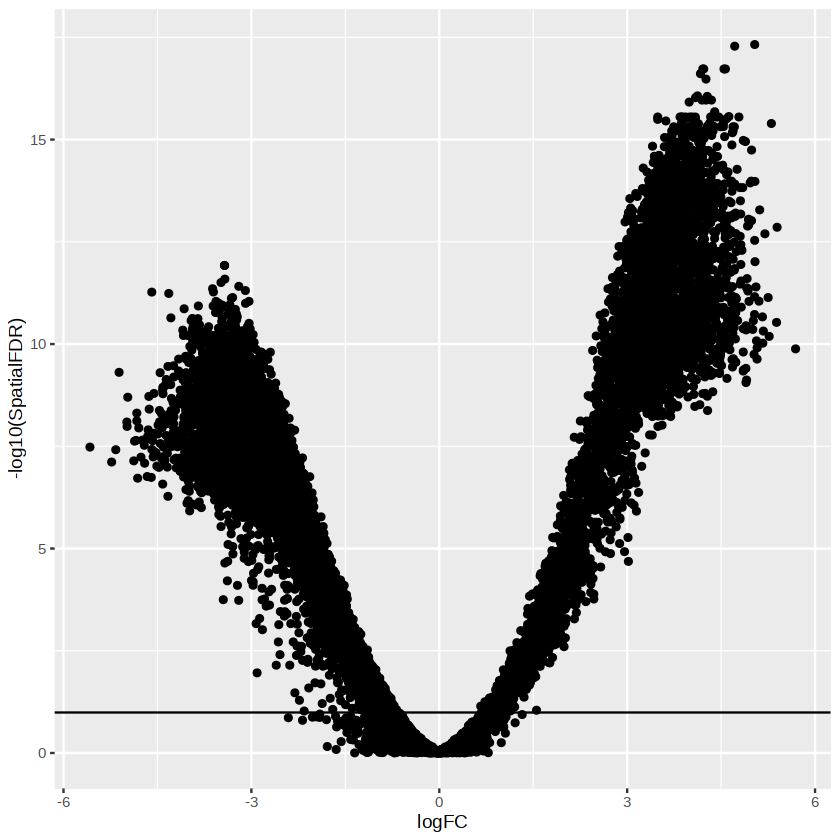

In [25]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [26]:
milo <- buildNhoodGraph(milo)

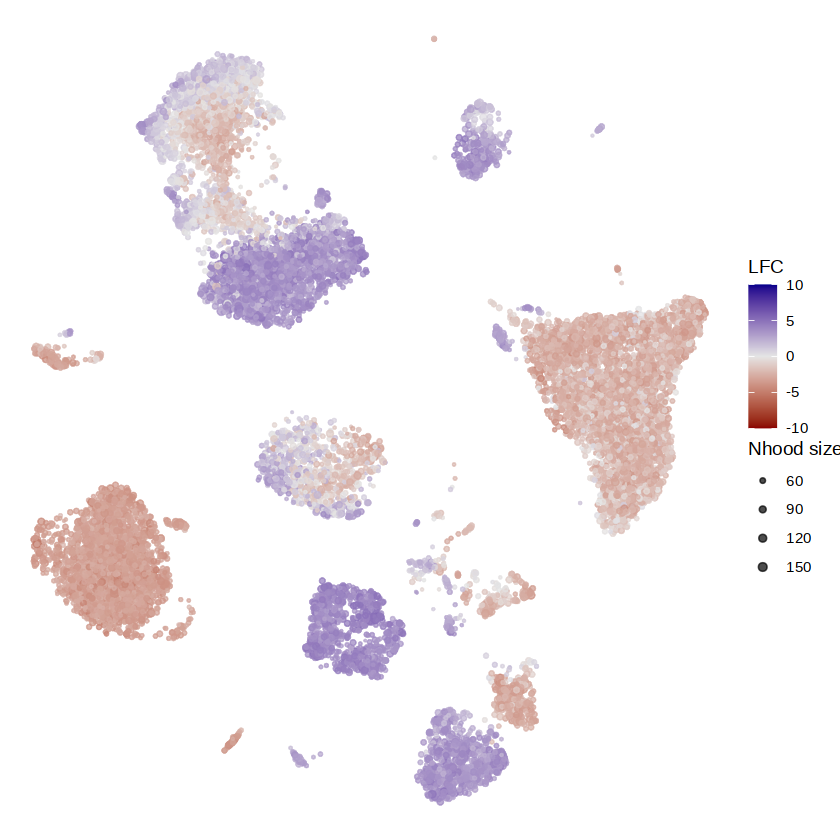

In [27]:
plotNhoodDA(milo,redDim = "X_umap",  da_results, alpha=0.7, size_scale = c(0.1, 2), color_scheme = da_colors)

In [28]:
da_results <- annotateNhoods(milo, da_results, coldata_col = "broad_cell_type")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,broad_cell_type,broad_cell_type_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-2.8649995,7.931665,40.7773600,8.553417e-09,2.226686e-08,1,2.132664e-08,classical_monocyte,0.9772727
2,0.3178253,8.099392,0.5381046,4.645998e-01,4.930518e-01,2,4.911817e-01,NKT_cell,0.7945205
3,2.9041107,8.183735,47.1791422,2.693186e-10,1.111536e-09,3,1.073448e-09,CD8_T_cell,0.7777778
4,3.9188385,8.129559,69.3292548,2.524282e-12,1.936828e-11,4,1.872371e-11,CD8_T_cell,0.8983051
5,3.5018002,8.005225,69.3837939,2.487977e-12,1.915176e-11,5,1.850880e-11,collecting_duct,1.0000000
6,-1.8538949,7.882534,25.1733197,1.900666e-06,2.981727e-06,6,2.902638e-06,NKT_cell,0.6279070


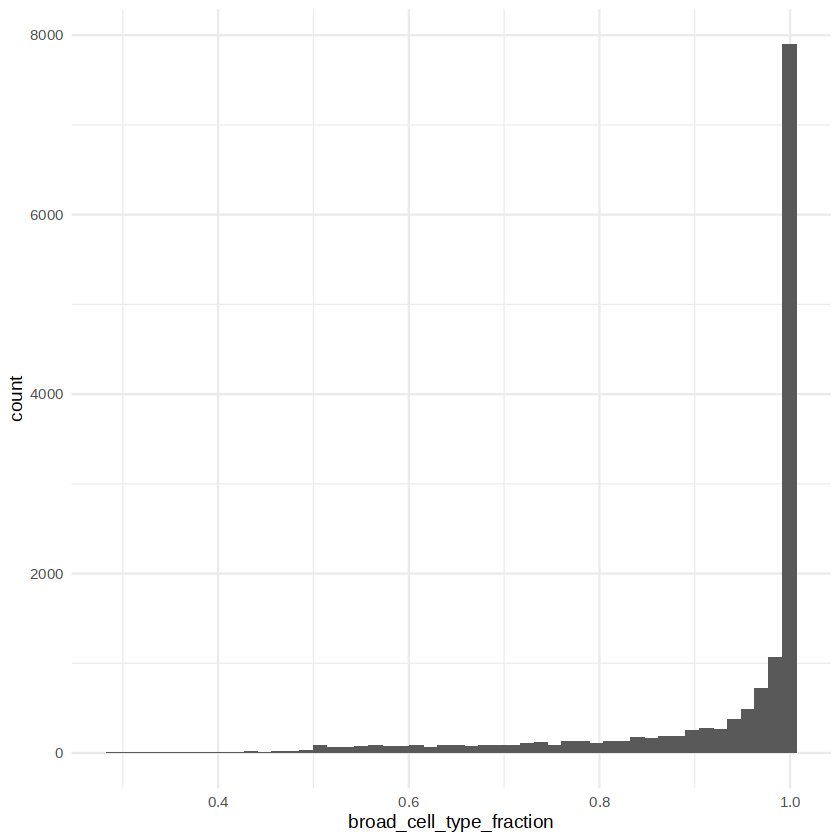

In [29]:
ggplot(da_results, aes(broad_cell_type_fraction)) + geom_histogram(bins=50) + theme_minimal()

In [30]:
da_results$broad_cell_type <- ifelse(da_results$broad_cell_type_fraction < 0.7, "Mixed", da_results$broad_cell_type)

Converting group_by to factor...



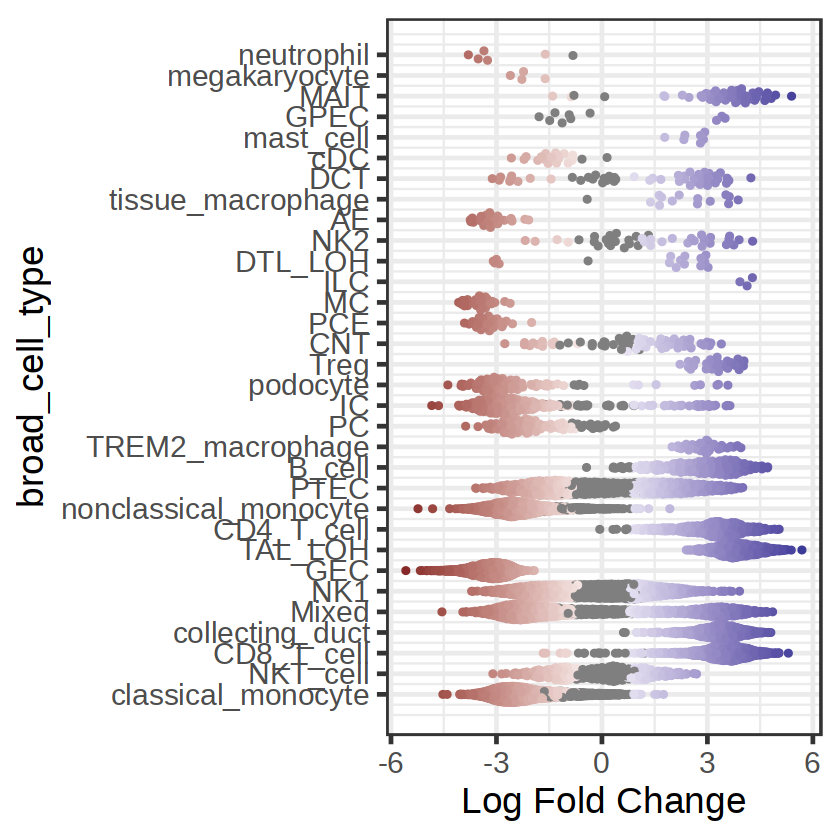

In [31]:
plotDAbeeswarm(da_results, group.by = "broad_cell_type")

In [32]:
#save the milo result
setwd("/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response")
saveRDS(milo, "data/da_results/glomTI/glomTI_milo.RDS")
saveRDS(da_results, "data/da_results/glomTI/da_results.RDS")

In [33]:
#get immune compartment
adata = sc$read_h5ad("./data/annotated/scRNAseq_glom_TI_kidney_immune_compartment.h5ad")

In [34]:
#subset to glom and TI
adata = adata[adata$obs$tissue %in% c("Glomerulus_single_cell_suspension", "TI_compartment_single_cell_suspension")]

In [35]:
adata = adata[adata$obs$compartment %in% c("immune_myeloid", "immune_lymphoid")]

In [36]:
#construct an SCE
library(SingleCellExperiment)

In [37]:
sce = SingleCellExperiment(assays = list('counts' = t(adata$layers['raw_counts']), 'exprs' = t(adata$X) ),
                                    colData = adata$obs, rowData = adata$var)

In [38]:
reducedDims(sce) = list('X_scVI' = adata$obsm['X_scVI'], 'X_umap' = adata$obsm['X_umap'])

In [39]:
table(sce$compartment)


immune_lymphoid  immune_myeloid 
          50106           47682 

In [40]:
#make a milo object for this analysis
milo <- Milo(sce)

In [41]:
#build the k=30 kNN graph
d = ncol(reducedDim(sce, 'X_scVI'))
k = 30
milo <- buildGraph(milo, k = k, d=d, reduced.dim = "X_scVI")

Constructing kNN graph with k:30



In [42]:
milo <- makeNhoods(milo, prop = 0.1, k = k, d=d, refined = TRUE, reduced_dims = "X_scVI")

Checking valid object

Running refined sampling with reduced_dim



In [43]:
milo <- calcNhoodDistance(milo, d=d, reduced.dim = "X_scVI")

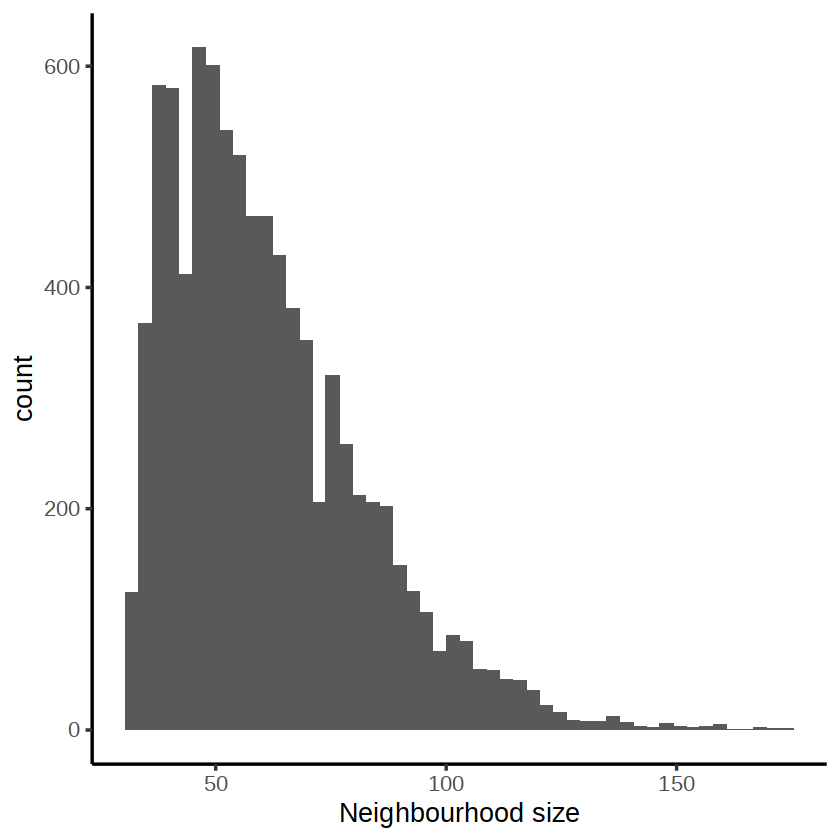

In [44]:
plotNhoodSizeHist(milo)

In [45]:
table(colData(milo)$donor)


     GPD1      K232      K241      K245      K247 K250_K251      K254      K255 
      452      7051      7190      4255      7092     12038      5026      3669 
     K257      K260      K262      K269      K270      K271      K272      K273 
     2987      1328      1699      3202     10281     11258      1247      3231 
     K275      K277      K278      K294 
     3069      6889      1055      4769 

In [46]:
colData(milo)$replicate = paste0(colData(milo)$donor, "_", colData(milo)$channel) #kidneys are across multiple channels, so we have more replicates.

In [47]:
milo <- countCells(milo, meta.data = as.data.frame(colData(milo)), sample="replicate")

Checking meta.data validity

Counting cells in neighbourhoods



In [48]:
#get a design
design <- data.frame(colData(milo))[,c("replicate", "tissue")]

In [49]:
design <- dplyr::distinct(design)
rownames(design) <- design$replicate

In [50]:
da_results <- testNhoods(milo, design = ~ tissue, norm.method = 'logMS',
                         design.df = design, reduced.dim = 'X_scVI')

Using logMS normalisation

Performing spatial FDR correction withk-distance weighting



In [51]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2426,5.026558,9.400653,137.9851,3.322055e-22,2.923741e-18,2426,2.368114e-18
6067,4.741520,9.207967,132.3801,1.332222e-21,5.862445e-18,6067,5.031544e-18
6137,4.444542,9.112557,128.5076,3.539680e-21,1.038424e-17,6137,8.515811e-18
1372,4.286723,9.031677,125.2808,8.082225e-21,1.740477e-17,1372,1.472274e-17
6905,4.248726,9.005706,124.4989,9.887948e-21,1.740477e-17,6905,1.472274e-17
4914,4.482127,9.160933,122.9921,1.460972e-20,2.143003e-17,4914,1.769221e-17


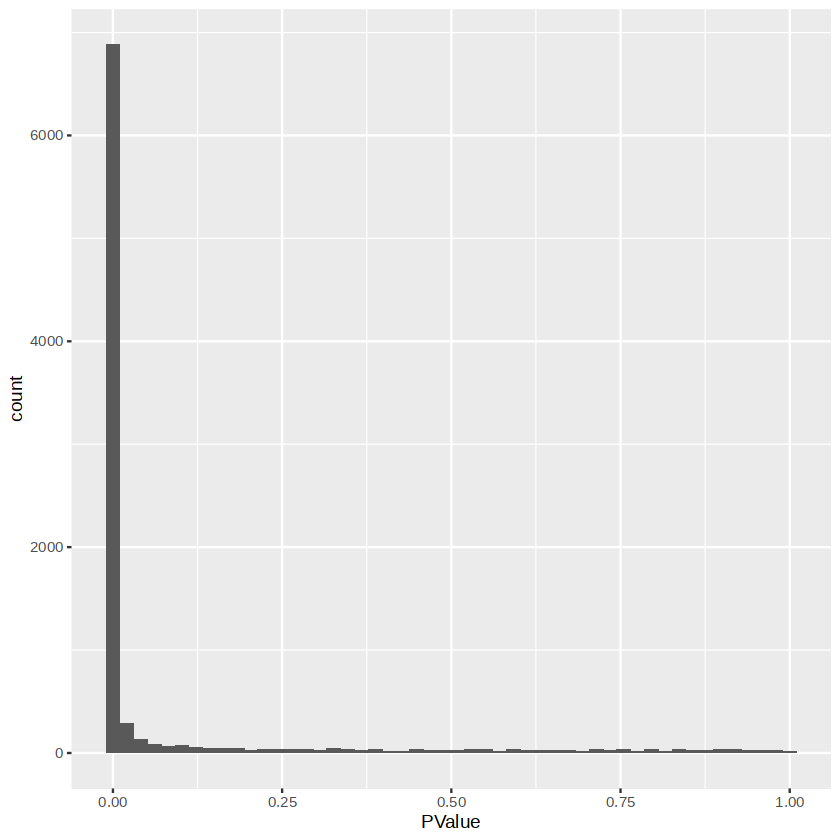

In [52]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

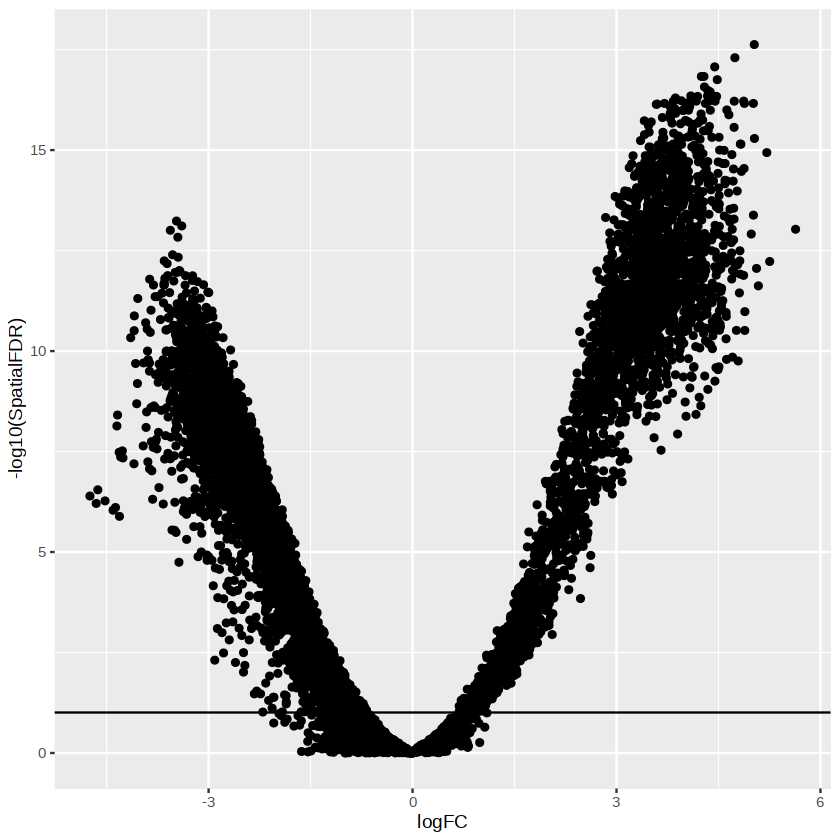

In [53]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [54]:
milo <- buildNhoodGraph(milo)

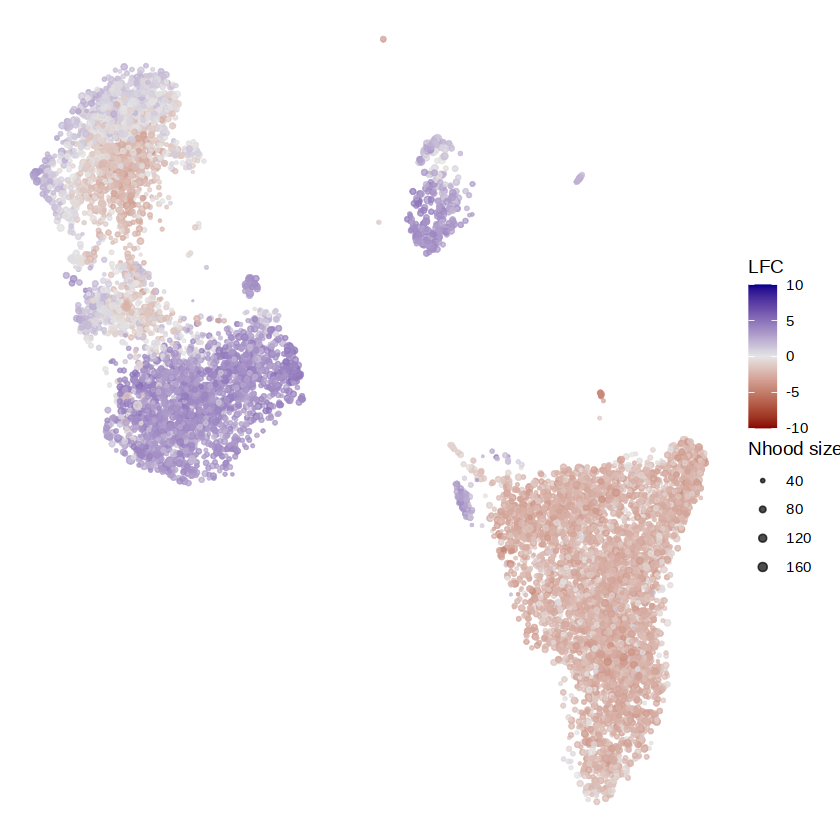

In [55]:
plotNhoodDA(milo,redDim = "X_umap",  da_results, alpha=0.7, size_scale = c(0.1, 2), color_scheme = da_colors)

In [56]:
da_results <- annotateNhoods(milo, da_results, coldata_col = "broad_cell_type")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,broad_cell_type,broad_cell_type_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.4605265,8.689295,0.5880002,4.445739e-01,4.846643e-01,1,4.834411e-01,classical_monocyte,1.0000000
2,-2.8702605,8.941185,44.4781560,6.555482e-10,2.418055e-09,2,2.349162e-09,classical_monocyte,1.0000000
3,-2.6993837,8.769353,34.2307851,3.709219e-08,8.929112e-08,3,8.728325e-08,nonclassical_monocyte,1.0000000
4,-1.4170696,8.726627,12.3356841,6.103631e-04,8.646073e-04,4,8.573091e-04,NKT_cell,0.8870968
5,-2.8119509,8.752518,53.7456799,2.110530e-11,1.137463e-10,5,1.109432e-10,classical_monocyte,0.9864865
6,-0.6568559,8.768784,2.6253340,1.075763e-01,1.260691e-01,6,1.255680e-01,classical_monocyte,1.0000000


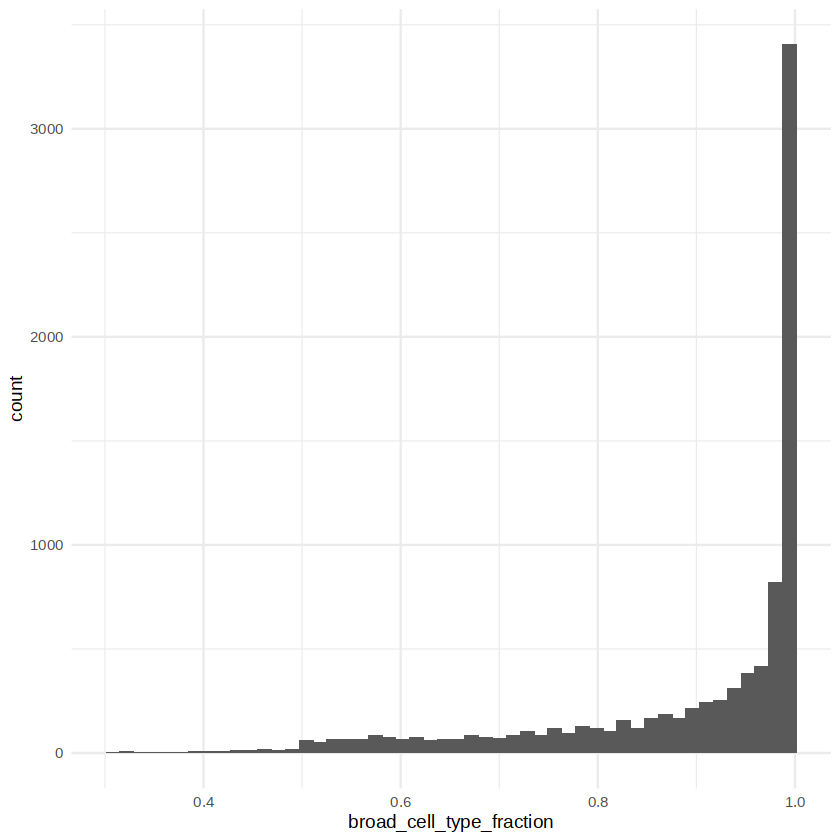

In [57]:
ggplot(da_results, aes(broad_cell_type_fraction)) + geom_histogram(bins=50) + theme_minimal()

In [58]:
da_results$broad_cell_type <- ifelse(da_results$broad_cell_type_fraction < 0.7, "Mixed", da_results$broad_cell_type)

Converting group_by to factor...



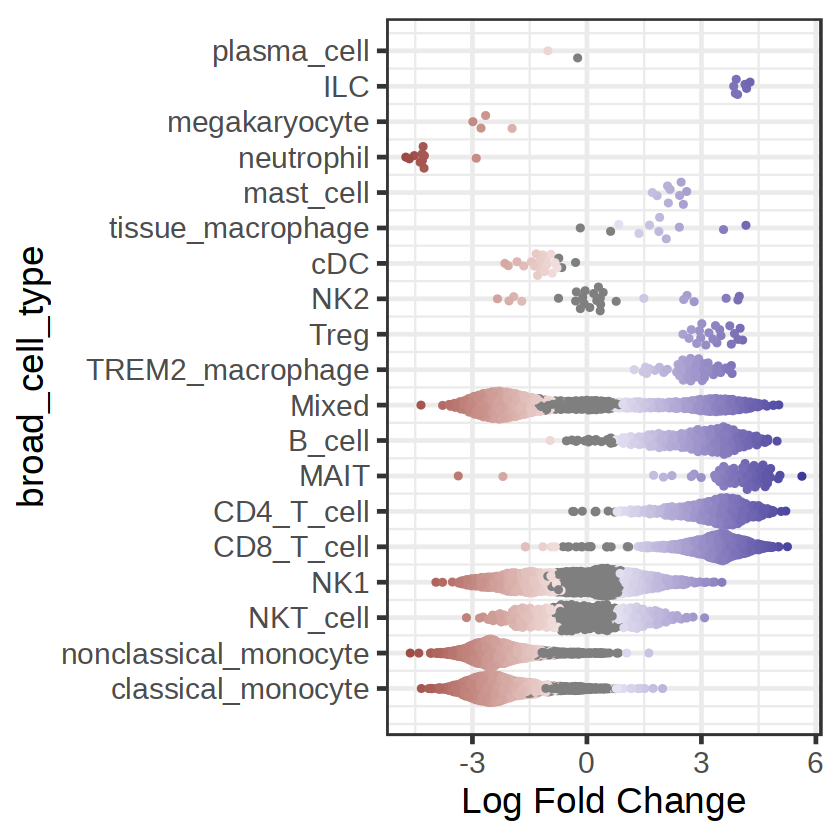

In [59]:
plotDAbeeswarm(da_results, group.by = "broad_cell_type")

In [60]:
#save the milo result
saveRDS(milo, "data/da_results/glomTI/glomTI_milo_immune.RDS")
saveRDS(da_results, "data/da_results/glomTI/da_results_immune.RDS")